In [1]:
import numpy as np
import matplotlib.pyplot as plt
from DasTools import DasPrep as dp
# %matplotlib ipympl
%matplotlib inline

### Read metadata from the data file

In [2]:
# fname = 'N:\\czyc\\test3\\czyc_3km_GL_10m_frq_1kHz_sp_2m_UTC_20240104_181042.357.h5'
fname = '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_2m_UTC_20240104_181042.357.h5'

metadata = dp.read_das(fname, metadata=True)

for key in metadata.keys():
    print(key, ':', metadata[key])

dt : 0.001
nt : 15000
dx : 2.0419039726257324
nch : 1472
GL : 10.0
headers : {'AcquisitionDescription': b'', 'AcquisitionId': b'97a305b1-697e-446d-cbd1-b01db256935e', 'FacilityId': array([b'TBD'], dtype='|S3'), 'GaugeLength': 10.0, 'GaugeLength.uom': b'm', 'MaximumFrequency': 500.0, 'MaximumFrequency.uom': b'Hz', 'MeasurementStartTime': b'2024-01-03T14:05:12.357560+00:00', 'MinimumFrequency': 0.0, 'MinimumFrequency.uom': b'Hz', 'NumberOfLoci': 1472, 'PulseRate': 16000.0, 'PulseRate.uom': b'Hz', 'PulseWidth': 50.0, 'PulseWidth.uom': b'ns', 'ServiceCompanyName': b'Silixa', 'SpatialSamplingInterval': 2.0419039726257324, 'SpatialSamplingInterval.uom': b'm', 'StartLocusIndex': 0, 'TriggeredMeasurement': False, 'schemaVersion': b'2.1', 'uuid': b'f926c602-a0d6-4d7f-aca5-6c12845db14e'}


### Read DAS raw data from the data file

In [3]:
%%time
data = dp.read_das(fname)
print(data.shape)  # data shape convention: (number of channels, number of time samples)

(1472, 15000)
CPU times: user 5.41 ms, sys: 16.5 ms, total: 21.9 ms
Wall time: 493 ms


In [4]:
%%time
data = dp.read_das(fname, ch1 = 20)
print(data.shape)

(1452, 15000)
CPU times: user 3.62 ms, sys: 18.6 ms, total: 22.2 ms
Wall time: 204 ms


### Preview the raw data

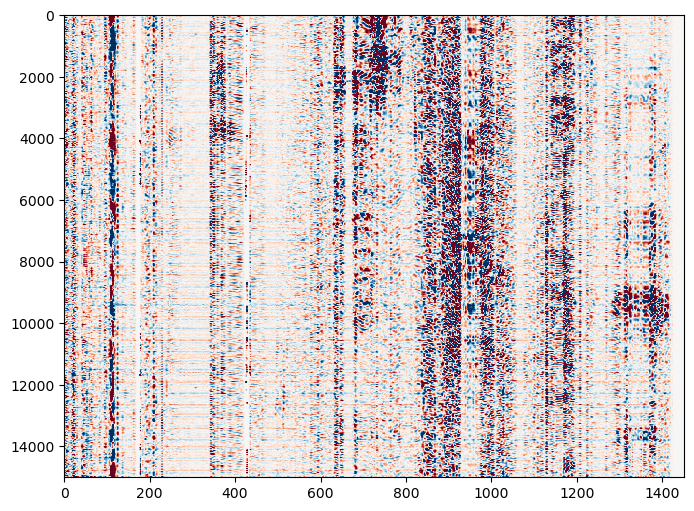

In [5]:
plt.figure(figsize=[8,6])

data_plot = data[:, :]
clim = data_plot.std() / 10
plt.imshow(data_plot.T, aspect='auto', cmap='RdBu', vmin=-clim, vmax=clim)

### Detrend data, remove common-mode noise, and plot data

In [6]:
# preprocessing / common-mode noise removal
data1 = dp.das_preprocess(data)

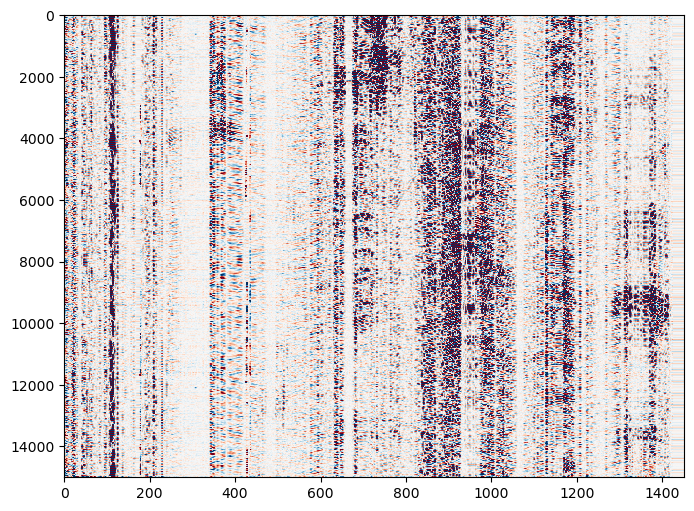

In [7]:
plt.figure(figsize=[8,6])

data_plot = data1[:, :]
clim = data_plot.std() / 10
plt.imshow(data_plot.T, aspect='auto', cmap='RdBu', vmin=-clim, vmax=clim)

### Filter and plot data

In [8]:
# data filtering (channel-by-channel)
dt = metadata['dt']
data2 = dp.tapering(data1, 0.2)
data2 = dp.lowpass(data2, dt, fh=1)
data2 = dp.das_preprocess(data2)

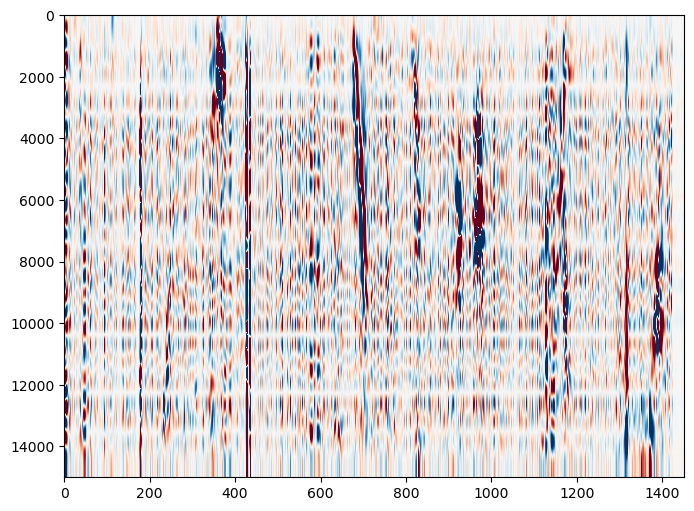

In [9]:
plt.figure(figsize=[8,6])

data_plot = data2[:, :]
clim = data_plot.std() 
plt.imshow(data_plot.T, aspect='auto', cmap='RdBu', vmin=-clim, vmax=clim)

### Calculate frequency spectrum

Numpy中的rfft()函数是用于实现基于FFT算法的实数数组的快速傅里叶变换的函数。使用rfft()函数可以将实数序列快速转换为复数序列，从而实现频率域上的计算操作。
fft.rfftfreq(n, d=1.0)返回离散傅立叶变换采样频率（用于rfft、irfft）返回离散傅立叶变换采样频率

In [10]:
spec = np.fft.rfft(data1, axis=1)
faxis = np.fft.rfftfreq(data1.shape[1], metadata['dt'])

Text(0, 0.5, 'Frequency (Hz)')

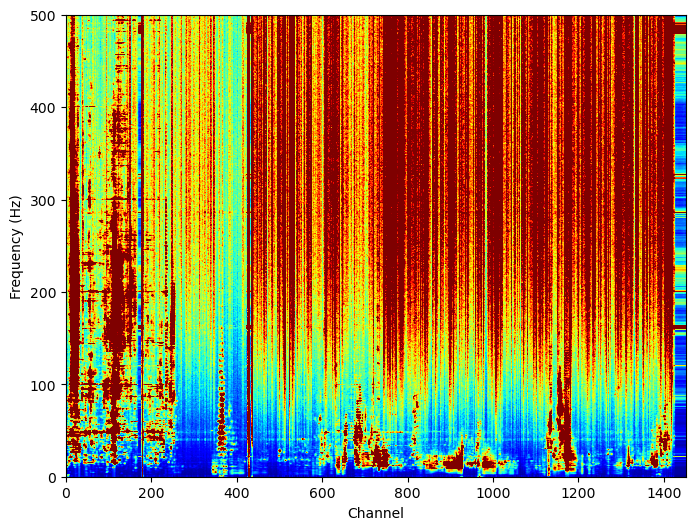

In [11]:
plt.figure(figsize=[8,6])

data_plot = abs(spec[:, :])
clim = data_plot.std() 
extent = [0, data_plot.shape[0], faxis[0], faxis[-1]]
plt.imshow(data_plot.T, aspect='auto', cmap='jet', vmin=0, vmax=clim, 
           origin='lower', extent=extent)

plt.xlabel('Channel')
plt.ylabel('Frequency (Hz)')

### FK transform

In [12]:
fk = np.fft.fftshift(np.fft.fft2(data1))
faxis = np.fft.fftshift(np.fft.fftfreq(data1.shape[1], metadata['dt']))
kaxis = np.fft.fftshift(np.fft.fftfreq(data1.shape[0], metadata['dx']))

Text(0, 0.5, 'Frequency (Hz)')

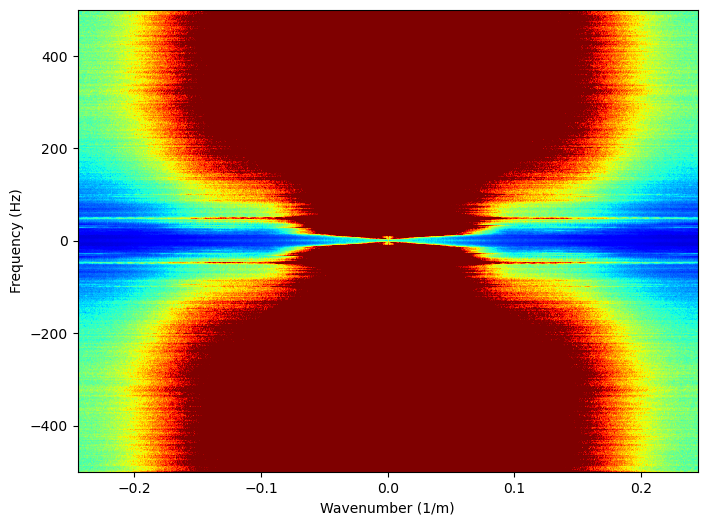

In [13]:
plt.figure(figsize=[8,6])

data_plot = abs(fk[:, :])
clim = data_plot.std() 
extent = [kaxis[0], kaxis[-1], faxis[0], faxis[-1]]
plt.imshow(data_plot.T, aspect='auto', cmap='jet', vmin=0, vmax=clim, 
           origin='lower', extent=extent)

plt.xlabel('Wavenumber (1/m)')
plt.ylabel('Frequency (Hz)')

(0.0, 0.2)

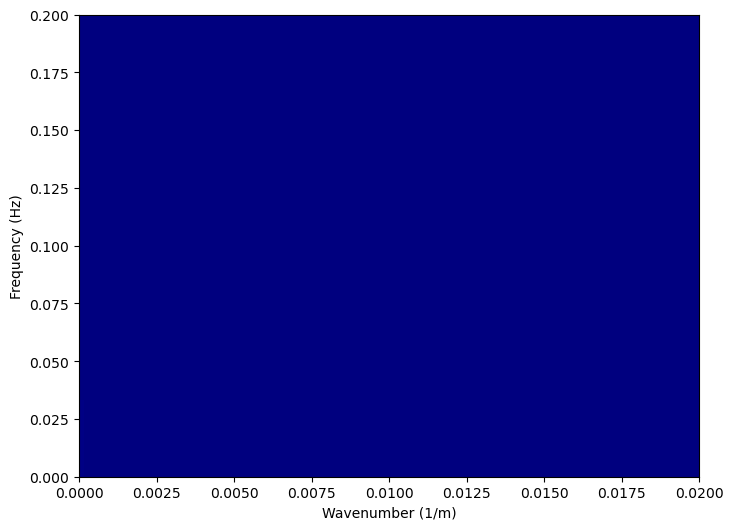

In [14]:
plt.figure(figsize=[8,6])

data_plot = abs(fk[:, :])
clim = data_plot.std() * 500
extent = [kaxis[0], kaxis[-1], faxis[0], faxis[-1]]
plt.imshow(data_plot.T, aspect='auto', cmap='jet', vmin=0, vmax=clim, 
           origin='lower', extent=extent)

plt.xlabel('Wavenumber (1/m)')
plt.ylabel('Frequency (Hz)')

plt.xlim(0,0.02)
plt.ylim(0,0.2)

### Concatenate and decimate data

In [15]:
import glob
from scipy import signal

# %matplotlib ipympl


flist = glob.glob('../../czyc/test3/*.h5')
flist.sort()
flist

['../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_1m_UTC_20240103_135942.940.h5',
 '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_1m_UTC_20240103_135957.940.h5',
 '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_1m_UTC_20240103_140012.940.h5',
 '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_1m_UTC_20240103_140027.940.h5',
 '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_1m_UTC_20240103_140042.940.h5',
 '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_1m_UTC_20240103_140057.940.h5',
 '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_1m_UTC_20240103_140112.940.h5',
 '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_1m_UTC_20240103_140127.940.h5',
 '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_1m_UTC_20240103_140142.940.h5',
 '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_1m_UTC_20240103_140157.940.h5',
 '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_1m_UTC_20240103_140212.940.h5',
 '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_2m_UTC_20240103_132655.028.h5',
 '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_2m_UT

In [16]:
# np.where(np.array(flist)=='N:\\czyc\\test3\\czyc_3km_GL_10m_frq_1kHz_sp_2m_UTC_20240104_063542.357.h5')
# np.where(np.array(flist)=='N:\\czyc\\test3\\czyc_3km_GL_10m_frq_1kHz_sp_2m_UTC_20240104_065342.357.h5')
np.where(np.array(flist)=='../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_2m_UTC_20240104_065342.357.h5')

(array([4061]),)

In [17]:
# metadata = dp.read_das(flist[6769], metadata=True)

metadata = dp.read_das(flist[3969], metadata=True)


for key in metadata.keys():
    print(key, ':', metadata[key])

dt : 0.001
nt : 15000
dx : 2.0419039726257324
nch : 1472
GL : 10.0
headers : {'AcquisitionDescription': b'', 'AcquisitionId': b'97a305b1-697e-446d-cbd1-b01db256935e', 'FacilityId': array([b'TBD'], dtype='|S3'), 'GaugeLength': 10.0, 'GaugeLength.uom': b'm', 'MaximumFrequency': 500.0, 'MaximumFrequency.uom': b'Hz', 'MeasurementStartTime': b'2024-01-03T14:05:12.357560+00:00', 'MinimumFrequency': 0.0, 'MinimumFrequency.uom': b'Hz', 'NumberOfLoci': 1472, 'PulseRate': 16000.0, 'PulseRate.uom': b'Hz', 'PulseWidth': 50.0, 'PulseWidth.uom': b'ns', 'ServiceCompanyName': b'Silixa', 'SpatialSamplingInterval': 2.0419039726257324, 'SpatialSamplingInterval.uom': b'm', 'StartLocusIndex': 0, 'TriggeredMeasurement': False, 'schemaVersion': b'2.1', 'uuid': b'f926c602-a0d6-4d7f-aca5-6c12845db14e'}


In [18]:
# flist[6755:6785]


# flist[3989-4:3989+0]
flist[4061-1:4061+2]

['../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_2m_UTC_20240104_065327.357.h5',
 '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_2m_UTC_20240104_065342.357.h5',
 '../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_2m_UTC_20240104_065357.357.h5']

In [19]:
%%time
datalist = []

# for fname in flist[6755:6785]:
for fname in flist[4061-1:4061+2]:

    datalist.append(dp.read_das(fname, ch1=400, ch2=1000))
    # datalist.append(dp.read_das(fname))


data = np.concatenate(datalist, axis=1)

print(data.shape)

M = 1
# data = signal.decimate(data, M, axis=1)
# metadata['dt'] *= M

# print(data.shape)

# preprocessing / common-mode noise removal
data1 = dp.das_preprocess(data)
# print(M*dt)
data1 = dp.bandpass(data1, M*dt,fl=1, fh=200)

(600, 45000)
CPU times: user 1.92 s, sys: 4.25 s, total: 6.17 s
Wall time: 3.18 s


In [ ]:
# %matplotlib auto
plt.figure(figsize=[8,8])

data_plot = data1[:, :]
clim = data_plot.std() / 1
plt.imshow(data_plot.T, aspect='auto', cmap='seismic', vmin=-clim, vmax=clim)

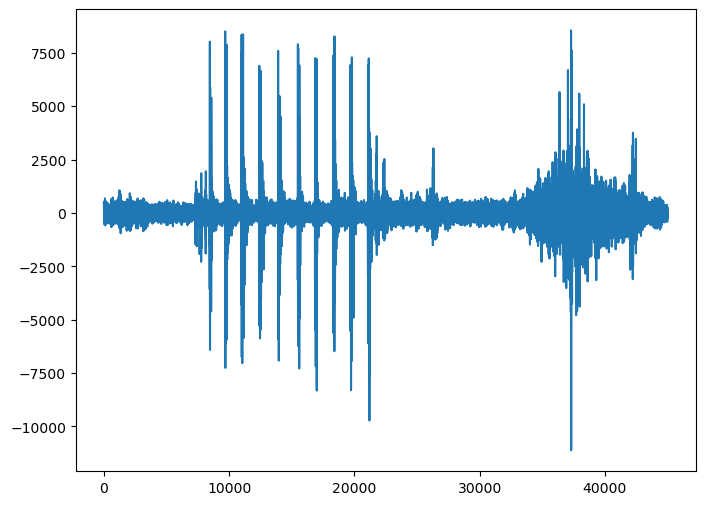

In [21]:
# %matplotlib inline
plt.figure(figsize=[8,6])
plt.plot(data_plot[490,:]) #ch1 = 400 

In [22]:
# np.where(np.array(flist)=='N:\\czyc\\test3\\czyc_3km_GL_10m_frq_1kHz_sp_2m_UTC_20240104_182412.357.h5')

# np.where(np.array(flist)=='N:\\czyc\\test3\\czyc_3km_GL_10m_frq_1kHz_sp_2m_UTC_20240104_181227.357.h5')
np.where(np.array(flist)=='../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_2m_UTC_20240104_181227.357.h5')




(array([6776]),)

In [23]:
%%time
datalist = []

# for fname in flist[6755:6785]:
# for fname in flist[6769-10:6769+10]:
for fname in flist[6776-5:6776+5]:

    datalist.append(dp.read_das(fname))

data = np.concatenate(datalist, axis=1)

print(data.shape)

M = 10
data = signal.decimate(data, M, axis=1)
metadata['dt'] *= M

print(data.shape)

# preprocessing / common-mode noise removal
data1 = dp.das_preprocess(data)
# data1 = dp.bandpass(data1, M*dt,fl=5, fh=200)

(1472, 150000)


: 

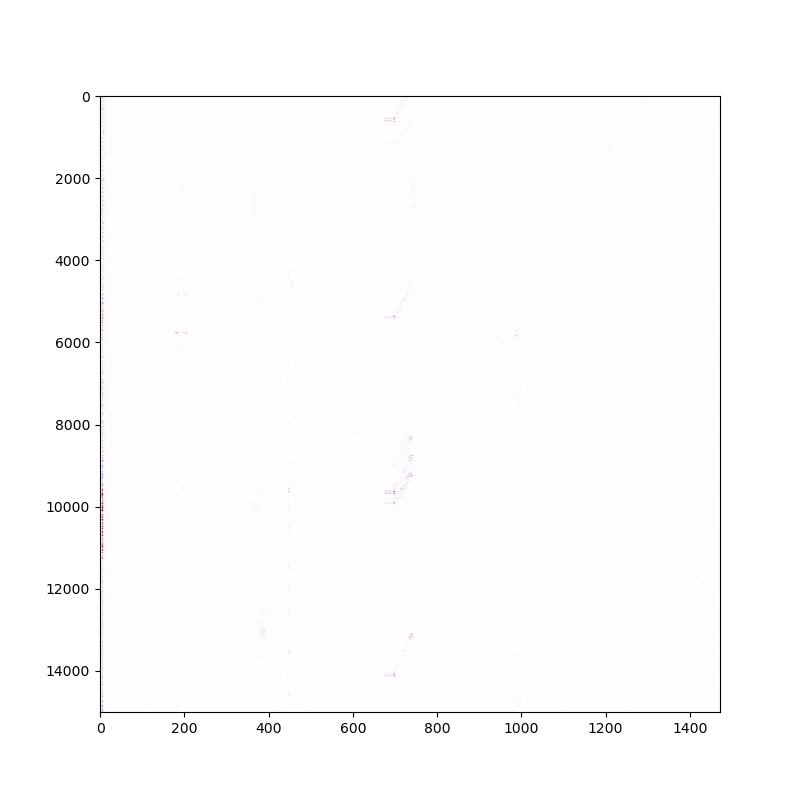

In [ ]:
# %matplotlib inline
plt.figure(figsize=[8,8])

data_plot = data1[:, :]
clim = data_plot.std() / 0.1
plt.imshow(data_plot.T, aspect='auto', cmap='seismic', vmin=-clim, vmax=clim)

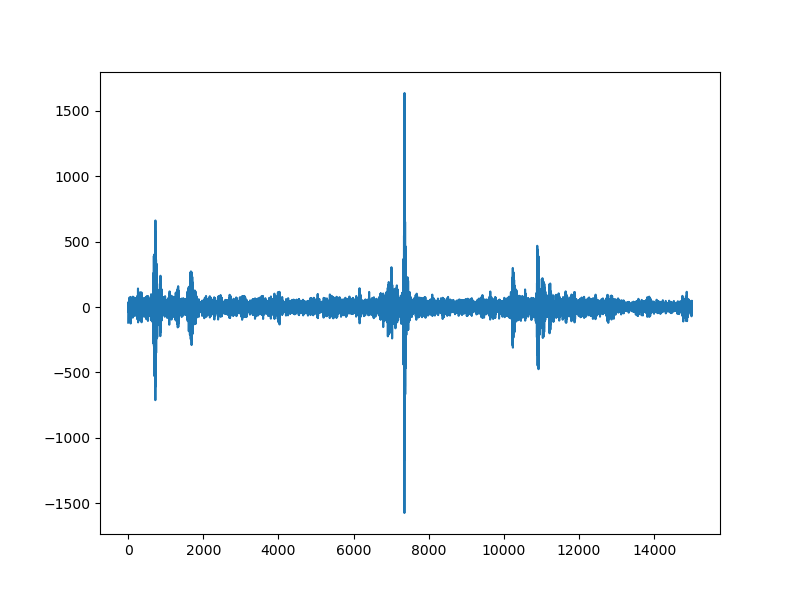

In [ ]:
# %matplotlib notebook
plt.figure(figsize=[8,6])
plt.plot(data_plot[888,:]) #ch1 = 0

In [ ]:
%%time
datalist = []
for fname in flist[6743:6823]:

    datalist.append(dp.read_das(fname, ch1=875, ch2=905))

data = np.concatenate(datalist, axis=1)

CPU times: user 293 ms, sys: 663 ms, total: 956 ms
Wall time: 55.4 s


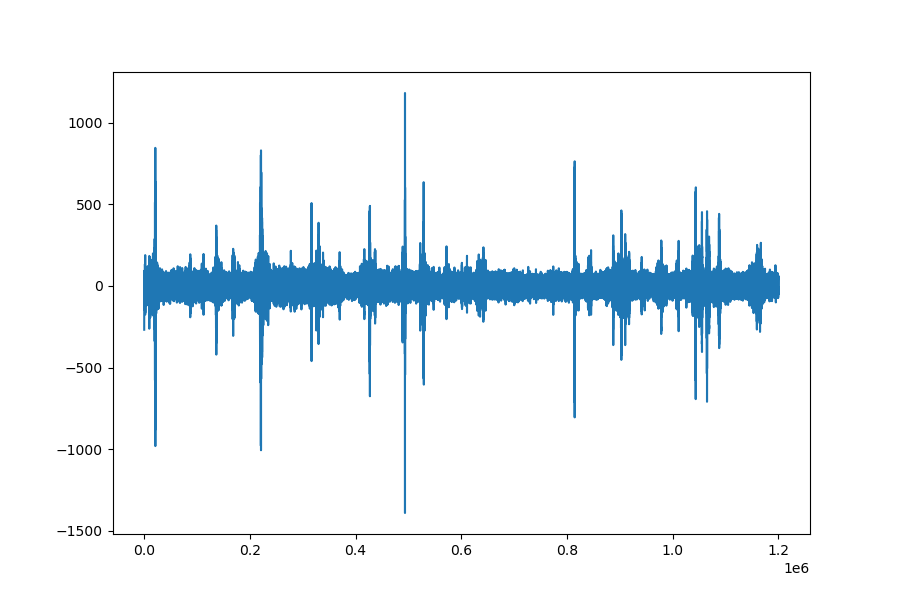

In [ ]:
# %matplotlib notebook
plt.figure(figsize=[9,6])
# data1 = dp.tapering(data, alpha=0.1)
data1 = dp.lowpass(data, dt, fh=100)
# plt.plot(np.log10(abs(data[5,:])))

plt.plot(data1[15,:])

In [ ]:
493500 // 15000

32

In [ ]:
flist[6743:6823][33]

'../../czyc/test3/czyc_3km_GL_10m_frq_1kHz_sp_2m_UTC_20240104_181227.357.h5'

In [ ]:
data1.shape

(30, 1200000)

In [ ]:
import audioop

das_fs = int(1./dt)
das_fs_deci = das_fs // 5
data1_deci_0 = np.ascontiguousarray((data1[15, :(data1.shape[1]//das_fs_deci*das_fs_deci)]).reshape((-1, das_fs_deci)))
# data1_db = np.array([20 * np.log10(audioop.rms(data1_deci_0[i],2)) for i in range(data1_deci_0.shape[0])])

data1_db = np.array([20 * np.log10(np.sqrt((data1_deci_0[i]**2).mean())) for i in range(data1_deci_0.shape[0])])

/tmp/ipykernel_1296/2517959661.py:1: DeprecationWarning: 'audioop' is deprecated and slated for removal in Python 3.13
  import audioop


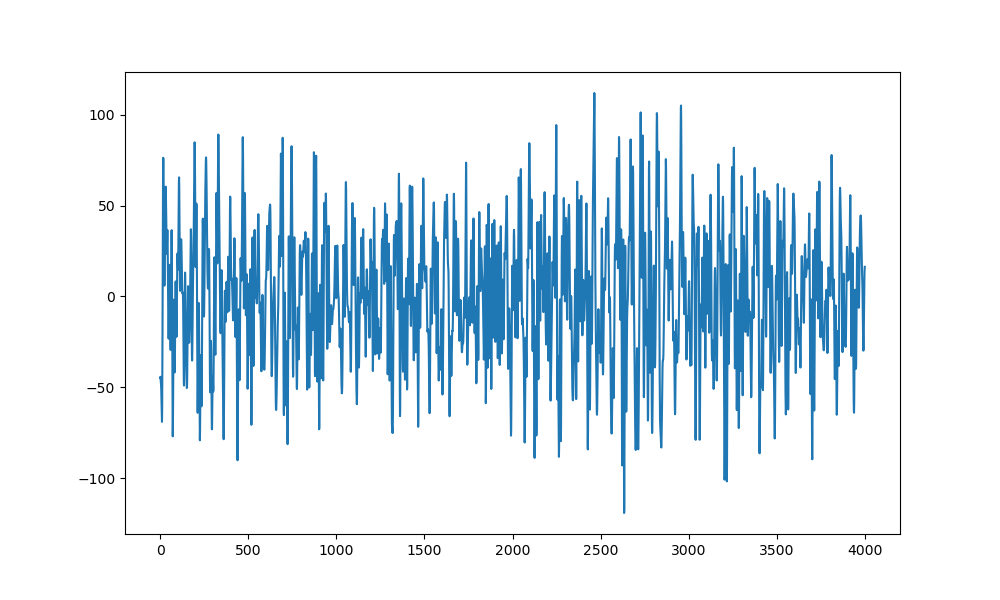

In [ ]:
plt.figure(figsize=[10,6])
# plt.plot(np.concatenate(data1_deci_0[2400:2500,:], axis=0))

plt.plot(np.concatenate(data1_deci_0[10:30,:], axis=0))

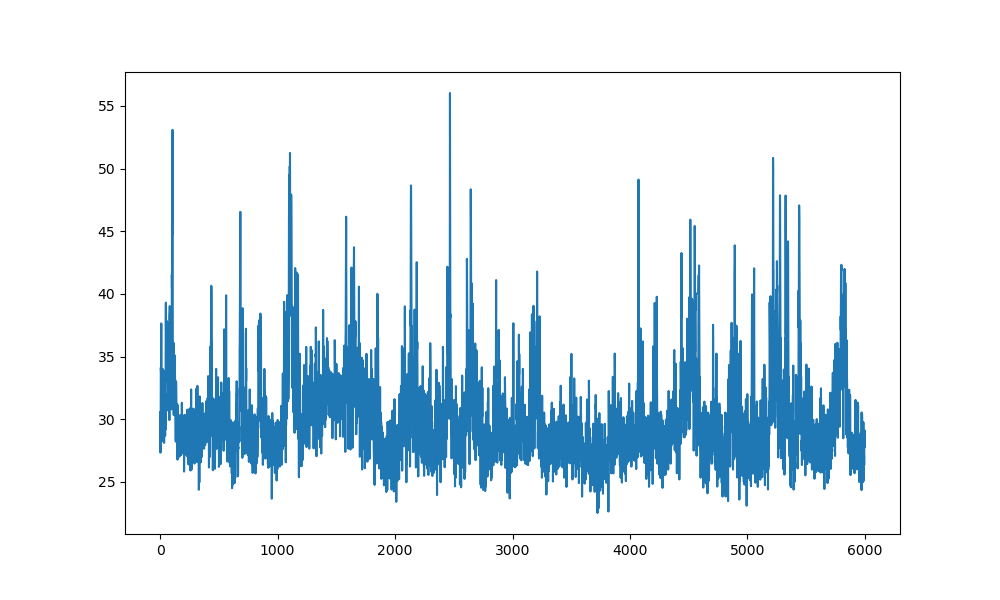

In [ ]:
plt.figure(figsize=[10,6])
plt.plot(data1_db,'-')

In [ ]:
data1_deci_0.shape

(6000, 200)

In [ ]:
493500//das_fs_deci

2467

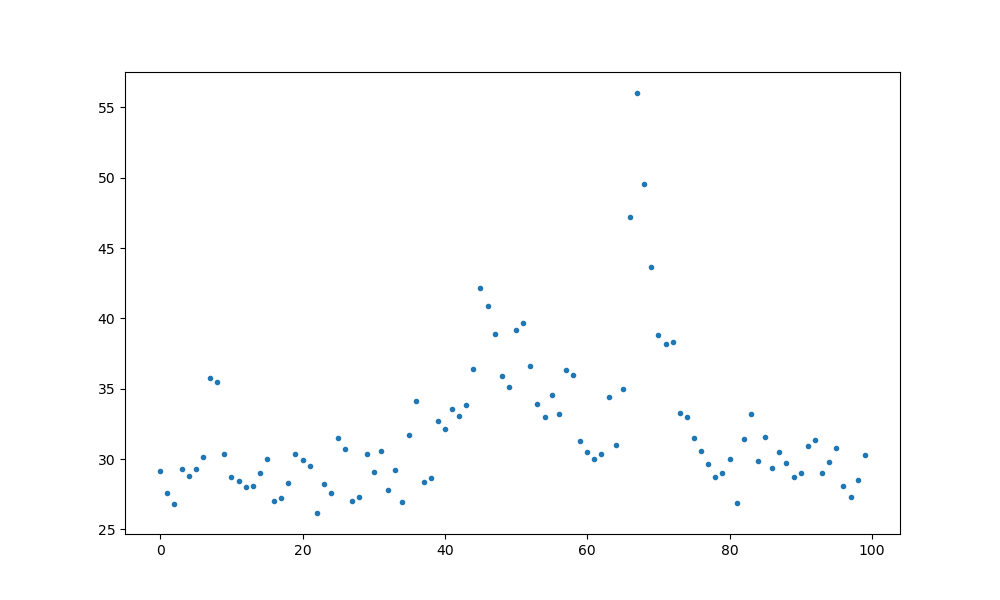

In [ ]:
plt.figure(figsize=[10,6])
# plt.plot(data1_db)
plt.plot(data1_db[2400:2500],'.')

In [ ]:
fk = np.fft.fftshift(np.fft.fft2(data1))
faxis = np.fft.fftshift(np.fft.fftfreq(data1.shape[1], metadata['dt']))
kaxis = np.fft.fftshift(np.fft.fftfreq(data1.shape[0], metadata['dx']))

(0.0, 0.2)

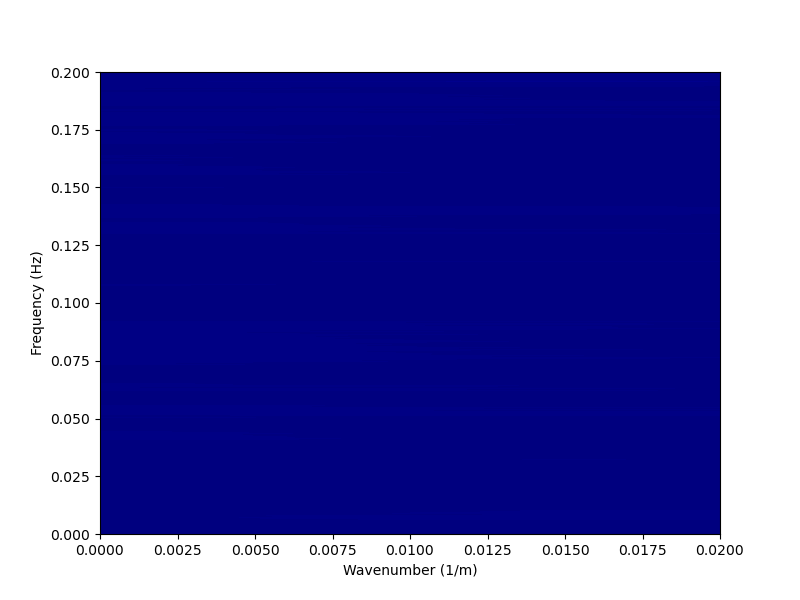

: 

In [ ]:
plt.figure(figsize=[8,6])

data_plot = abs(fk[:, :])
clim = data_plot.std() * 500
extent = [kaxis[0], kaxis[-1], faxis[0], faxis[-1]]
plt.imshow(data_plot.T, aspect='auto', cmap='jet', vmin=0, vmax=clim, 
           origin='lower', extent=extent)

plt.xlabel('Wavenumber (1/m)')
plt.ylabel('Frequency (Hz)')

plt.xlim(0,0.02)
plt.ylim(0,0.2)